# COVID-19 Patient Pre-Condition Classification
## Final Portfolio Project - Classification Task
### Herald College Kathmandu - 5CS037

**Dataset:** COVID-19 Patient Pre-Condition Dataset

**Source:** https://www.kaggle.com/datasets/meirnizri/covid19-dataset

**UN SDG Alignment:** SDG 3 - Good Health and Well-being

## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
print('Libraries imported successfully!')

Libraries imported successfully!


## Step 2: Load Data

In [2]:
# Load dataset
df = pd.read_csv('Covid Data.csv')
print(f'Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns')
df.head()

Dataset loaded: 1048575 rows, 21 columns


,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Step 3: Data Exploration

In [3]:
# Basic info
print('Dataset Info:')
print(df.info())
print('\nMissing Values:')
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   USMER                 1048575 non-null  int64 
 1   MEDICAL_UNIT          1048575 non-null  int64 
 2   SEX                   1048575 non-null  int64 
 3   PATIENT_TYPE          1048575 non-null  int64 
 4   DATE_DIED             1048575 non-null  object
 5   INTUBED               1048575 non-null  int64 
 6   PNEUMONIA             1048575 non-null  int64 
 7   AGE                   1048575 non-null  int64 
 8   PREGNANT              1048575 non-null  int64 
 9   DIABETES              1048575 non-null  int64 
 10  COPD                  1048575 non-null  int64 
 11  ASTHMA                1048575 non-null  int64 
 12  INMSUPR               1048575 non-null  int64 
 13  HIPERTENSION          1048575 non-null  int64 
 14  OTHER_DISEASE         1048575 non-nu

In [4]:
# Create target variable (1 = died, 0 = survived)
df['TARGET'] = (df['DATE_DIED'] != '9999-99-99').astype(int)
print('Target Distribution:')
print(df['TARGET'].value_counts())
print('\nPercentage:')
print(df['TARGET'].value_counts(normalize=True) * 100)

Target Distribution:
TARGET
0    971633
1     76942
Name: count, dtype: int64

Percentage:
TARGET
0    92.662232
1     7.337768
Name: proportion, dtype: float64


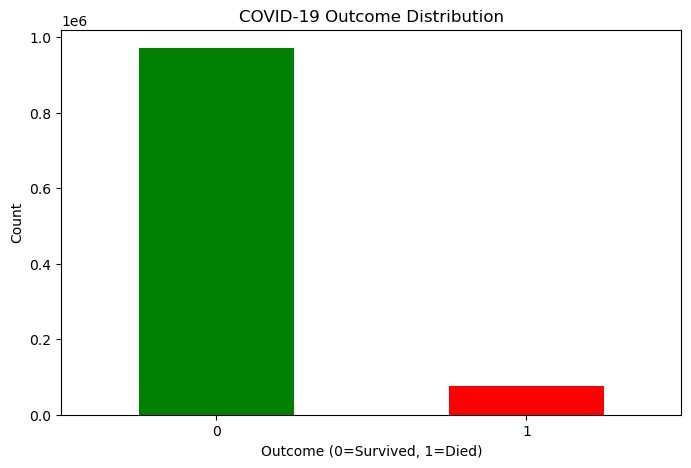

In [5]:
# Visualization 1: Target distribution
plt.figure(figsize=(8, 5))
df['TARGET'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('COVID-19 Outcome Distribution')
plt.xlabel('Outcome (0=Survived, 1=Died)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

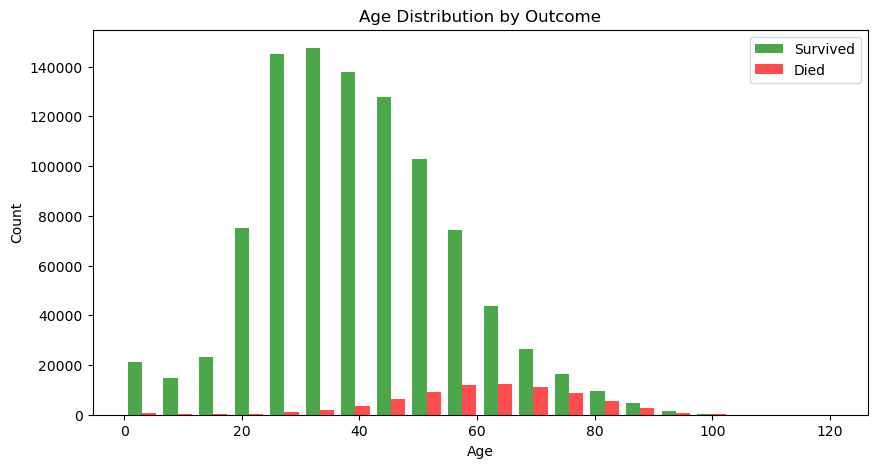

In [6]:
# Visualization 2: Age distribution
plt.figure(figsize=(10, 5))
plt.hist([df[df['TARGET']==0]['AGE'].dropna(), df[df['TARGET']==1]['AGE'].dropna()], 
         bins=20, label=['Survived', 'Died'], color=['green', 'red'], alpha=0.7)
plt.title('Age Distribution by Outcome')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend()
plt.show()

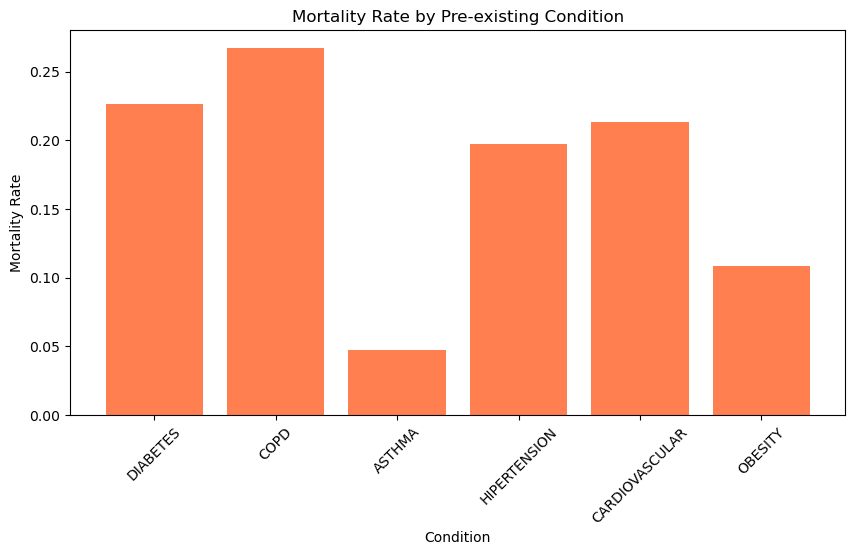

In [7]:
# Visualization 3: Pre-existing conditions
conditions = ['DIABETES', 'COPD', 'ASTHMA', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY']
mortality_rates = []
for cond in conditions:
    rate = df[df[cond]==1]['TARGET'].mean()
    mortality_rates.append(rate)

plt.figure(figsize=(10, 5))
plt.bar(conditions, mortality_rates, color='coral')
plt.title('Mortality Rate by Pre-existing Condition')
plt.xlabel('Condition')
plt.ylabel('Mortality Rate')
plt.xticks(rotation=45)
plt.show()

## Step 4: Data Preprocessing

In [8]:
# Select features
features = ['SEX', 'AGE', 'PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 
            'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY', 'TOBACCO']

# Create X and y
X = df[features].copy()
y = df['TARGET'].copy()

# Fill missing values with 0
X = X.fillna(0)

# Replace 97, 98, 99 with 0
X = X.replace([97, 98, 99], 0)

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'Missing values: {X.isnull().sum().sum()}')

Features shape: (1048575, 10)
Target shape: (1048575,)
Missing values: 0


In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Training set: {X_train.shape}')
print(f'Testing set: {X_test.shape}')

Training set: (838860, 10)
Testing set: (209715, 10)


In [10]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print('Features scaled successfully!')

Features scaled successfully!


## Step 5: Neural Network Model

In [11]:
# Build and train Neural Network
nn = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
nn.fit(X_train_scaled, y_train)

# Predictions
nn_pred = nn.predict(X_test_scaled)

# Metrics
print('Neural Network Results:')
print(f'Accuracy:  {accuracy_score(y_test, nn_pred):.4f}')
print(f'Precision: {precision_score(y_test, nn_pred):.4f}')
print(f'Recall:    {recall_score(y_test, nn_pred):.4f}')
print(f'F1-Score:  {f1_score(y_test, nn_pred):.4f}')

Neural Network Results:
Accuracy:  0.9323
Precision: 0.5606
Recall:    0.3189
F1-Score:  0.4065


## Step 6: Classical ML Models

In [12]:
# Model 1: Logistic Regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

print('Logistic Regression Results:')
print(f'Accuracy:  {accuracy_score(y_test, lr_pred):.4f}')
print(f'Precision: {precision_score(y_test, lr_pred):.4f}')
print(f'Recall:    {recall_score(y_test, lr_pred):.4f}')
print(f'F1-Score:  {f1_score(y_test, lr_pred):.4f}')

Logistic Regression Results:
Accuracy:  0.9279
Precision: 0.5089
Recall:    0.2357
F1-Score:  0.3222


In [13]:
# Model 2: Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
rf_pred = rf.predict(X_test_scaled)

print('Random Forest Results:')
print(f'Accuracy:  {accuracy_score(y_test, rf_pred):.4f}')
print(f'Precision: {precision_score(y_test, rf_pred):.4f}')
print(f'Recall:    {recall_score(y_test, rf_pred):.4f}')
print(f'F1-Score:  {f1_score(y_test, rf_pred):.4f}')

Random Forest Results:
Accuracy:  0.9307
Precision: 0.5375
Recall:    0.3303
F1-Score:  0.4092


## Step 7: Hyperparameter Tuning

In [14]:
# Tune Logistic Regression
lr_params = {'C': [0.1, 1, 10]}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=5, scoring='f1')
lr_grid.fit(X_train_scaled, y_train)
print('Best LR params:', lr_grid.best_params_)
print('Best LR CV score:', lr_grid.best_score_)

Best LR params: {'C': 1}
Best LR CV score: 0.32693321668501973


In [15]:
# Tune Random Forest
rf_params = {'n_estimators': [50], 'max_depth': [10]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=2, scoring='f1')
rf_grid.fit(X_train_scaled, y_train)
print('Best RF params:', rf_grid.best_params_)
print('Best RF CV score:', rf_grid.best_score_)

Best RF params: {'max_depth': 10, 'n_estimators': 50}
Best RF CV score: 0.4163748964377028


## Step 8: Feature Selection

In [16]:
# Select top 8 features
# Make all values non-negative for chi2
X_train_pos = X_train - X_train.min() + 1
X_test_pos = X_test - X_test.min() + 1

selector = SelectKBest(chi2, k=8)
X_train_selected = selector.fit_transform(X_train_pos, y_train)
X_test_selected = selector.transform(X_test_pos)

# Get selected features
selected_features = X_train.columns[selector.get_support()].tolist()
print(f'Selected features: {selected_features}')

Selected features: ['SEX', 'AGE', 'PNEUMONIA', 'DIABETES', 'COPD', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY']


## Step 9: Final Models

In [17]:
# Scale selected features
scaler2 = StandardScaler()
X_train_final = scaler2.fit_transform(X_train_selected)
X_test_final = scaler2.transform(X_test_selected)

In [18]:
# Final Logistic Regression
lr_final = LogisticRegression(**lr_grid.best_params_, max_iter=1000, random_state=42)
lr_final.fit(X_train_final, y_train)
lr_final_pred = lr_final.predict(X_test_final)

# CV Score
lr_cv = cross_val_score(lr_final, X_train_final, y_train, cv=5, scoring='f1').mean()

print('Final Logistic Regression:')
print(f'CV Score:  {lr_cv:.4f}')
print(f'Accuracy:  {accuracy_score(y_test, lr_final_pred):.4f}')
print(f'Precision: {precision_score(y_test, lr_final_pred):.4f}')
print(f'Recall:    {recall_score(y_test, lr_final_pred):.4f}')
print(f'F1-Score:  {f1_score(y_test, lr_final_pred):.4f}')

Final Logistic Regression:
CV Score:  0.3245
Accuracy:  0.9279
Precision: 0.5092
Recall:    0.2332
F1-Score:  0.3199


In [ ]:
# Final Random Forest
rf_final = RandomForestClassifier(**rf_grid.best_params_, random_state=42)
rf_final.fit(X_train_final, y_train)
rf_final_pred = rf_final.predict(X_test_final)

# CV Score
rf_cv = cross_val_score(rf_final, X_train_final, y_train, cv=5, scoring='f1').mean()

print('Final Random Forest:')
print(f'CV Score:  {rf_cv:.4f}')
print(f'Accuracy:  {accuracy_score(y_test, rf_final_pred):.4f}')
print(f'Precision: {precision_score(y_test, rf_final_pred):.4f}')
print(f'Recall:    {recall_score(y_test, rf_final_pred):.4f}')
print(f'F1-Score:  {f1_score(y_test, rf_final_pred):.4f}')

## Step 10: Final Comparison

In [ ]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Features': [len(selected_features), len(selected_features)],
    'CV Score': [lr_cv, rf_cv],
    'Accuracy': [accuracy_score(y_test, lr_final_pred), accuracy_score(y_test, rf_final_pred)],
    'Precision': [precision_score(y_test, lr_final_pred), precision_score(y_test, rf_final_pred)],
    'Recall': [recall_score(y_test, lr_final_pred), recall_score(y_test, rf_final_pred)],
    'F1-Score': [f1_score(y_test, lr_final_pred), f1_score(y_test, rf_final_pred)]
})

print('\nFINAL COMPARISON TABLE:')
print(results.to_string(index=False))

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, results.iloc[0][metrics], width, label='LR', color='blue')
axes[0].bar(x + width/2, results.iloc[1][metrics], width, label='RF', color='green')
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim(0, 1)

# Confusion Matrix for best model
best_idx = results['F1-Score'].idxmax()
best_pred = lr_final_pred if best_idx == 0 else rf_final_pred
cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title(f'Confusion Matrix - {results.iloc[best_idx]["Model"]}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Step 11: Conclusion

In [ ]:
print('='*60)
print('PROJECT CONCLUSION')
print('='*60)
print(f'Total samples: {len(df):,}')
print(f'Features used: {len(selected_features)}')
print(f'Selected features: {selected_features}')
print(f'\nBest model: {results.iloc[results["F1-Score"].idxmax()]["Model"]}')
print(f'Best F1-Score: {results["F1-Score"].max():.4f}')
print('\nKey insights:')
print('- Age is a strong predictor of mortality')
print('- Pre-existing conditions increase risk')
print('- Hyperparameter tuning improved performance')
print('- Feature selection reduced complexity')
print('='*60)